In [1]:
import os
import sys
import pickle as pickle
import time
import numpy as np
import h5py

os.environ["DATAPATH"]= '/home/jiaming/taxidemand_deepst/scripts/papers/AAAI17'

import torch
import torch.nn as nn
import torch.utils.data as data_utils
from torch.autograd import Variable
from livelossplot import PlotLosses
from tqdm import tqdm as pbar
from deepst.models.STResNet import stresnet
from deepst.config import Config
import deepst.metrics as metrics
from deepst.datasets import TaxiNYC

Using TensorFlow backend.


In [2]:
len_closeness = 3  # length of closeness dependent sequence
len_period = 1  # length of peroid dependent sequence
len_trend = 1  # length of trend dependent sequence
T = 24  # number of time intervals in one day
nb_flow = 2  # there are two types of flows: inflow and outflow
# divide data into two subsets: Train & Test, of which the test set is the
# last 4 weeks
days_test = 73 #3 * 7 * 4
len_test = T * days_test
map_height, map_width = 32, 32  # grid size

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, mmn, metadata_dim, timestamp_train, timestamp_test = TaxiNYC.load_data(
    T=T, nb_flow=nb_flow, len_closeness=len_closeness, len_period=len_period, len_trend=len_trend, len_test=len_test,
    preprocess_name='preprocessing.pkl', meta_data=False, meteorol_data=False, holiday_data=False)

file name:  /home/jiaming/taxidemand_deepst/scripts/papers/AAAI17/TaxiNYC/NYC16.h5


/home/jiaming/miniconda3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


=====stat=====
data shape: (17545, 2, 32, 32)
# of days: 732, from 2014-07-01 to 2016-07-01
# of timeslots: 35136
# of timeslots (available): 17545
missing ratio of timeslots: 50.1%
max: 3150.000, min: 0.000
=====stat=====
[b'2014070101' b'2014070102' b'2014070103' ... b'2016063023' b'2016063024'
 b'2016070101']
incomplete days:  [b'20160701']


train_data shape:  (17544, 2, 32, 32) 1752 24
min: 0.0 max: 3150.0
XC shape:  (17376, 6, 32, 32) XP shape:  (17376, 2, 32, 32) XT shape:  (17376, 2, 32, 32) Y shape: (17376, 2, 32, 32)
len_closeness= 3 len_period= 1 len_trend= 1
XC shape:  (17376, 3, 2, 32, 32) XP shape:  (17376, 1, 2, 32, 32) XT shape:  (17376, 1, 2, 32, 32) Y shape: (17376, 2, 32, 32)
train shape: (15624, 3, 2, 32, 32) (15624, 2, 32, 32) test shape:  (1752, 3, 2, 32, 32) (1752, 2, 32, 32)
(15624, 3, 2, 32, 32)
(15624, 1, 2, 32, 32)
(15624, 1, 2, 32, 32)

(1752, 3, 2, 32, 32)
(1752, 1, 2, 32, 32)
(1752, 1, 2, 32, 32)



In [3]:
m_train = len(Y_train_orig)
m_test = len(Y_test_orig)
X_train_temp = torch.zeros((m_train, 5, 2, 32, 32), dtype=torch.float64)
X_test_temp = torch.zeros((m_test, 5, 2, 32, 32), dtype=torch.float64)

for i in range(m_train):
    X_train_temp[i, 0:3] = torch.from_numpy(X_train_orig[0][i])
    X_train_temp[i, 3] = torch.from_numpy(X_train_orig[1][i])
    X_train_temp[i, 4] = torch.from_numpy(X_train_orig[2][i])
    
for i in range(m_test):
    X_test_temp[i, 0:3] = torch.from_numpy(X_test_orig[0][i])
    X_test_temp[i, 3] = torch.from_numpy(X_test_orig[1][i])
    X_test_temp[i, 4] = torch.from_numpy(X_test_orig[2][i])

    
X_train = X_train_temp.view(-1, 5, 2, 32, 32)
Y_train = torch.from_numpy(Y_train_orig).view(-1, 2, 32, 32)
X_test = X_test_temp.view(-1, 5, 2, 32, 32)
Y_test = torch.from_numpy(Y_test_orig).view(-1, 2, 32, 32)

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print()
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_test.shape)
    

Shape of X_train: torch.Size([15624, 5, 2, 32, 32])
Shape of Y_train: torch.Size([15624, 2, 32, 32])

Shape of X_test: torch.Size([1752, 5, 2, 32, 32])
Shape of Y_train: torch.Size([1752, 2, 32, 32])


In [4]:
# X_train = torch.load('data/X_train.pt').float()
# Y_train = torch.load('data/Y_train.pt').float()
# X_test = torch.load('data/X_test.pt').float()
# Y_test = torch.load('data/Y_test.pt').float()

print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_test.shape)
# Create Pytorch Dataset
train_dataset = data_utils.TensorDataset(X_train, Y_train)
test_dataset = data_utils.TensorDataset(X_test, Y_test)

# Create Pytorch train Loader and Test Loader (to load each batch)
batch_size = 128
trainloader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {"train": trainloader, "validation": testloader}
dataset_sizes = {"train": len(train_dataset), "validation": len(test_dataset)}

Shape of X_train: torch.Size([15624, 5, 2, 32, 32])
Shape of Y_train: torch.Size([15624, 2, 32, 32])
Shape of X_test: torch.Size([1752, 5, 2, 32, 32])
Shape of Y_train: torch.Size([1752, 2, 32, 32])


In [5]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        
        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding     = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias        = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)).cuda(1),
                Variable(torch.zeros(batch_size, self.hidden_dim, self.height, self.width)).cuda(1))


class ConvLSTM(nn.Module):

    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim  = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = input_size

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(input_size=(self.height, self.width),
                                          input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        
        Parameters
        ----------
        input_tensor: todo 
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
            
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        
        #initlize the hidden state
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1) #[64, 5, 2, 32, 32]
            cur_layer_input = layer_output #[64, 5, 2, 32, 32]

            layer_output_list.append(layer_output) # number_layer * [64, 5, 2, 32, 32]
            last_state_list.append([h, c]) # number_layer * layer[h, c]

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list   = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [6]:
class Fcl_net(nn.Module):
    def __init__(self, input_size):
        super(Fcl_net, self).__init__()
        map_height, map_width = input_size
        self.convlstm1 = ConvLSTM(input_size=(map_height, map_width),input_dim=2,hidden_dim=[64, 64],kernel_size=(3, 3),num_layers=2,
                 batch_first=True,bias=True,return_all_layers=False)
        self.bn1 = nn.BatchNorm3d(5)
        self.convlstm2 = ConvLSTM(input_size=(map_height, map_width),input_dim=64,hidden_dim=[32, 32],kernel_size=(3, 3),num_layers=2,
                 batch_first=True,bias=True,return_all_layers=False)
        self.bn2 = nn.BatchNorm3d(5)
        self.convlstm3 = ConvLSTM(input_size=(map_height, map_width),input_dim=32,hidden_dim=[32, 32],kernel_size=(3, 3),num_layers=2,
                 batch_first=True,bias=True,return_all_layers=False)
        self.bn3 = nn.BatchNorm3d(5)
        self.convlstm4 = ConvLSTM(input_size=(map_height, map_width),input_dim=32,hidden_dim=[32, 32],kernel_size=(3, 3),num_layers=2,
                 batch_first=True,bias=True,return_all_layers=False)
        self.bn4 = nn.BatchNorm3d(5)
        self.relu = nn.ReLU()
        self.convlstm5 = ConvLSTM(input_size=(map_height, map_width),input_dim=32,hidden_dim=[32, 2],kernel_size=(3, 3),num_layers=2,
                 batch_first=True,bias=True,return_all_layers=False)
        
    def forward(self, x):
        layer_output_list1, last_state_list1 = self.convlstm1(x)
        x = self.bn1(layer_output_list1[0])
        layer_output_list2, last_state_list2 = self.convlstm2(x)
        x = self.bn2(layer_output_list2[0])
        layer_output_list3, last_state_list3 = self.convlstm3(x)
        x = self.bn3(layer_output_list3[0])
        layer_output_list4, last_state_list4 = self.convlstm4(x)
        x = self.bn4(layer_output_list4[0])
        x = self.relu(x)
        layer_output_list5, last_state_list5 = self.convlstm5(x)
        
        return last_state_list5[-1][0]
        

In [7]:
def unnormalize(X):
    # Return the un-normalized form of X
    data_max = 3150.0
    data_min = 0
    return X * (data_max - data_min) / 2.0
MAX = 3150.0
def inverse_transform(X):
    # Return the un-normalized form of X
    return X * (mmn._max - mmn._min) / 2

In [8]:
# train on cuda if available
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

def train_model(model, criterion, optimizer, num_epochs):
    liveloss = PlotLosses()
    model = model.to(device)

    for epoch in pbar(range(num_epochs)):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            print("epoch", epoch)
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()

                # layer_output_list, last_state_list = model(inputs)
                output = model(inputs)
                
                loss = criterion(output, labels)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = unnormalize((running_loss/dataset_sizes[phase])**0.5)
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'
            logs[prefix + 'RMSE Loss'] = epoch_loss
        
        liveloss.update(logs)
        liveloss.draw()

cuda:1


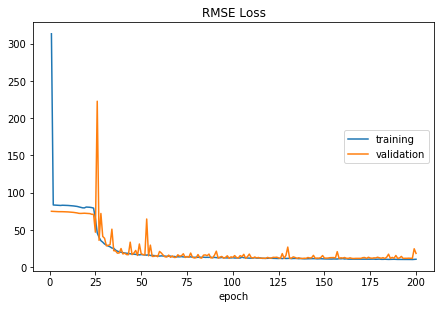

100%|██████████| 200/200 [5:19:26<00:00, 84.42s/it]

RMSE Loss:
training   (min:   10.107, max:  313.245, cur:   10.465)
validation (min:   11.466, max:  222.688, cur:   18.345)


In [9]:
# bulid the model 
# model = ConvLSTM(input_size=(map_height, map_width),input_dim=2,hidden_dim=[64, 64, 32],kernel_size=(3, 3),num_layers=3,
#                  batch_first=True,bias=True,return_all_layers=False)
model = Fcl_net(input_size=(map_height, map_width))
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, criterion, optimizer, num_epochs=200)

# train_model(model, criterion, optimizer, num_epochs=10)
torch.save(model.state_dict(), 'convlstm_model.pt')